
# Gaining Insight into Twitter Audiences through Personality Analysis
This project uses the Personality Insights Watson API to:
1- Understand the personality profile of the average follower of a twitter account
2- Segment those followers through kmeans clustering analysis into the most relevant segments based on the "Needs" features of the profile. This insight will be useful to marketing teams to optimize targeting and messaging to better meet those needs.


## How the project is done:

### 1- Accessing the Twitter API. 
The twitter API is accessed to get the list of followers for an account, and to get the tweets posted by each of those users.  Accessing this API has some complexities as twitter sets limits to the amount of data that can be accessed in a defined period of time.  The algorithm must be set to "sleep" when the rate maximum is reached, therefore it takes a long time to get all the necessary data and that is why it is also necessary to work with samples of the data and not all data.

How was this done?
- A list of "n" followers (i.e: 2,000, or 5,000) of a twitter account is read through the twitter API
- Out of those followers, a random sample of size "x" (i.e: 200, or 500) is obtained and a maximum of 3,200 tweets for each user is read (Twitter sets the limit of 3,200 tweets per follower if you don't have their authorization to get all data).

The reason to work with a smaller sample is the length of time it takes to read the data through the twitter API due to rate limits.  The algorithm could be set to read  up to 3,200 tweets of every follower of an account without using a sample.

### 2- Accessing the Watson Personality Insights API. 
Once the tweets have been read, the collection of tweets for each follower is passed to the Personality Insight API, and a personality profile is returned for each follower.  This API returns over 100 different metrics to represent this individual's personality.  

For details on the API: https://www.ibm.com/watson/developercloud/personality-insights/api/v3/

For understanding all the personality metrics and the science behind the API: https://console.bluemix.net/docs/services/personality-insights/index.html#about


### 3- Calculate the personality profile of the average follower
For the avegare personality profile I focused on metrics around the personality profile, needs and values

### 4- Identify natural segments through clustering analysis
For the clustering part of this project I focused on 12 metrics that are meant to represent each individual needs and represent 
the aspects of a product or service that will resonate with a person. I ran a kmeans clustering analysis to find the most representative segments based on these needs profiles. The "needs" data is represented in the following variables:

need_liberty
need_ideal
need_love
need_practicality
need_self_expression
need_stability
need_structure
need_challenge
need_closeness
need_curiosity
need_excitement
need_harmony

This information is represented as percentiles.

Additional analysis can also be made by looking at other metrics such as personality traits and consumption patterns

## Getting API Credentials

##Three sets of credentials need to be added

Twitter: You will need to create an application at https://apps.twitter.com/app/new.  Once it is created, you will get an access_key, access_secret, consumer_key, and consumer_secret needed for oauth authentication

Watson API: You will need a Bluemix (IBM's cloud) Account: https://console.bluemix.net/registration/
and a "Personality Insights API" Service: https://console.bluemix.net/docs/services/watson/getting-started-credentials.html#creating-credentials

In this project I am also using Object Storage on Bluemix to store the data

In [2]:
#Installing python api library
!pip install --upgrade python-twitter  

  Using cached https://files.pythonhosted.org/packages/e6/2c/9fc6565b57ce6f3cc8e20b6c4bde8960dd0857629d41654bce46a6dd0bf9/python_twitter-3.4.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/65/47/7e02164a2a3db50ed6d8a6ab1d6d60b69c4c3fdf57a284257925dfc12bda/requests-2.19.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/94/e7/c250d122992e1561690d9c0f7856dadb79d61fd4bdd0e598087dce607f6c/requests_oauthlib-1.0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/4b/2a/0276479a4b3caeb8a8c1af2f8e4355746a97fab05a372e4a2c6a6b876165/idna-2.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/df/f7/04fee6ac349e915b82171f8e23cee63644d83663b34c539f7a09aed18f9e/certifi-2018.8.24-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bd/c9/6fdd990019071a4a32a5e7cb78a1d92c53851ef4f56f62a3486e6a7d8ffb/urllib3-1.23-py2.py3-none-any.whl
  Using cached https://files.pythonhosted

In [3]:
#Installing Watson API Library
!pip install --upgrade watson-developer-cloud

  Using cached https://files.pythonhosted.org/packages/65/47/7e02164a2a3db50ed6d8a6ab1d6d60b69c4c3fdf57a284257925dfc12bda/requests-2.19.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/cf/f5/af2b09c957ace60dcfac112b669c45c8c97e32f94aa8b56da4c6d1682825/python_dateutil-2.7.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9d/fb/f51a03e232e00d6c504dfe815aed090c894ba3f8d3f7fd9612f3e227bf24/websocket_client-0.47.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/df/f7/04fee6ac349e915b82171f8e23cee63644d83663b34c539f7a09aed18f9e/certifi-2018.8.24-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/4b/2a/0276479a4b3caeb8a8c1af2f8e4355746a97fab05a372e4a2c6a6b876165/idna-2.7-py2.py3-none-any.whl
  Using cached https://files.pythonhost

In [4]:
#Import libraries
from io import StringIO
from math import sqrt
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.sql import SQLContext
import json
import matplotlib.pyplot as plt
import pandas as pd
import random
import re
import requests
import sys
import csv
import twitter   #Twitter wrapper for Twitter API
from watson_developer_cloud import PersonalityInsightsV3  #Watson Personality Insights API Library


In [5]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, 
#connections, and used by platform APIs.  THESE CREDENTIALS NEED TO BE ADDED
from project_lib import Project
project = Project(spark.sparkContext, 'PROJECTID', 'PROJECTTOKEN')
pc = project.project_context



In [6]:
#Twitter connection credentials THESE CREDENTIALS NEED TO BE ADDED
# @hidden_cell
def authorize_twitter():
    access_key = 'ACCESSKEY'
    access_secret = 'ACCESSSECRET'
    consumer_key = 'CONSUMERKEY'
    consumer_secret = 'CONSUMERSECRET'
    twitter_api = twitter.Api(consumer_key=consumer_key,
                          consumer_secret=consumer_secret,
                          access_token_key=access_key,
                          access_token_secret=access_secret,
                          debugHTTP=False,
                          sleep_on_rate_limit=True)
    return twitter_api


twitter_api=authorize_twitter()  # Need to create a twitter app to get credentials
#Remember a twitter app needs to be created to get credentials


In [7]:
# @hidden_cell  THESE CREDENTIALS NEED TO BE ADDED
#Instantiating access to the Watson API
watson_api=PersonalityInsightsV3(url='https://gateway.watsonplatform.net/personality-insights/api',version='2017-10-13',username='USERNAME',password='PASSWORD')


In [8]:
##Functions to interact with the TWITTER API: Getting followers of an account and getting the tweets for an account

#This function reads "n: sample_size" followers of a given twitter handle
def get_list_followers(twitter_api,account,sample_size):
    follower_list= twitter_api.GetFollowers(screen_name=account,total_count=sample_size)
    return follower_list

#Reads the tweets posted from the twitter "handle"
def get_tweets(handle, twitter_api):
    max_id = None
    statuses = []
    for x in range(0, 16):  # Pulls max number of tweets from an account
        if x == 0:
            try:
                statuses_portion = twitter_api.GetUserTimeline(screen_name=handle,
                                                               count=200,
                                                               include_rts=False)
            except:
                break
            status_count = len(statuses_portion)
            if status_count != 0: 
                max_id = statuses_portion[status_count - 1].id - 1  # get id of last tweet and bump below for next tweet set
            else: 
                x=16
        else:
            try:
                statuses_portion = twitter_api.GetUserTimeline(screen_name=handle,
                                                               count=200,
                                                               max_id=max_id,
                                                               include_rts=False)
            except:
                break
            status_count = len(statuses_portion)
            if status_count != 0:
                max_id = statuses_portion[status_count - 1].id - 1  # get id of last tweet and bump below for next tweet set
            else:
                x=16
        for status in statuses_portion:
                pi_content_items_array=[]
                clean_status=convert_status_to_pi_content_item(status)
                if  clean_status!= None:
                    statuses.append(clean_status['content'])
    return statuses
        

In [9]:
#Functions to interact with the WATSON PERSONALITY INSIGHTS API

#This function converts a twitter status into separate fields.
def convert_status_to_pi_content_item(s):
    # This code takes a tweet status object and returns a json structure for the status
    if s.lang == "en":
        return {
            'userid': str(s.user.id),
            'id': str(s.id),
            'sourceid': 'python-twitter',
            'contenttype': 'text/plain',
            'language': s.lang,
            'content':s.text,
            'created': s.created_at_in_seconds,
            'reply': (s.in_reply_to_status_id == None),
            'forward': False
            }
    else:
        return None
    
#Once tweets are read, this function is used to get the personality profile for the user that created those tweets

def get_Personality_insights(tweets):
    df=pd.DataFrame()
    pi_content_items = {'contentItems': tweets}
    try:
        response = watson_api.profile(pi_content_items,
                                      content_type="text/plain",
                                      accept="text/csv",
                                      csv_headers=True).get_result()

    except:
            pass 
    else:
        s=str(response.content,'utf-8')
        data = StringIO(s) 
        df=pd.read_csv(data)
                          
    return df  

In [10]:
#These functions are used to visualize the data returned by the Watson API

def plotadf(mydf,threshold,facets_title,graph_title):
    colors=[]
    for i, row in mydf.iteritems():
        if row < threshold:
            colors.append("red")
        else:
            if row > threshold+0.3:
                colors.append("magenta")
            else:
                colors.append("green")
    mydf.plot.barh(figsize=(8,6),color=colors,title=facets_title+graph_title)
                   #"- Green: IBM's is Higher than 50% of the Population"
    plt.show()
     
        
def plotalltraits(mycolumns, mydf,threshold,facets_title, graph_title):
    plotadf(mydf.loc[mycolumns].sort_values(),threshold,facets_title,graph_title)

In [11]:
#a simple case - personality profile for 1 twitter account
account="anamecheverri"

#GET TWEETS

tweets_list=get_tweets(account,twitter_api)  #Reads tweets for each follower - up to 3,200 maximum set by twitter 
print(tweets_list)

#GET PERSONALITY PROFILE DATA
PIscoresdf=get_Personality_insights(tweets_list)  #Calls Watson API to get Personality Profiles using the list of tweets as input

print(PIscoresdf)

['Mmmmm ok then! Amazon Reportedly Killed an #AI Recruitment System Because It Couldn’t Stop the Tool from Discrimina… https://t.co/bTBZbABVPF', 'Here’s How Men Can Be Leaders in Improving Corporate #Diversity https://t.co/s3nh7Kiy8J', 'Most universities haven’t provided pathways for digital natives to cross-train in policy and computer science by wo… https://t.co/XYGD8ZXV4H', 'Survey says... #DataScience and #MachineLearning are the top skills #developers want to learn https://t.co/7FsaSKYiJ7', 'Great functionality to extract information and context from unstructured text data so that it can be used like stru… https://t.co/N6V0hqJUNK', 'Great functionality to extract information and context from unstructured text data so that it can be used like stru… https://t.co/DRfhl6MkTP', 'Great functionality to extract information and context from unstructured text data so that it can be used like stru… https://t.co/o6JzjEHV9O', '.@IBM has introduced a number of targeted Watson #AI applications 

   big5_agreeableness  facet_altruism  facet_cooperation  facet_modesty  \
0            0.187234        0.089407           0.088538       0.145282   

   facet_morality  facet_sympathy  facet_trust  big5_conscientiousness  \
0         0.20416        0.554663     0.392664                0.521269   

   facet_achievement_striving  facet_cautiousness  \
0                    0.516982            0.589117   

                   ...                   need_challenge_significant  \
0                  ...                                         True   

   need_closeness_significant  need_curiosity_significant  \
0                        True                        True   

   need_excitement_significant  need_harmony_significant  \
0                         True                      True   

   value_conservation_significant  value_hedonism_significant  \
0                            True                        True   

   value_openness_to_change_significant  value_self_enhancement_significant

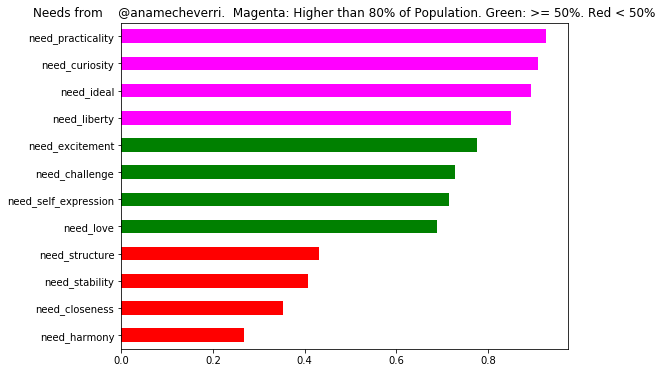

In [12]:
#Visualizing Data Example
#Needs Data

plotalltraits(["need_liberty","need_ideal","need_love","need_practicality","need_self_expression","need_stability","need_structure","need_challenge","need_closeness","need_curiosity","need_excitement","need_harmony"], PIscoresdf.iloc[0],0.5,"Needs from ","   @"+account+ ".  Magenta: Higher than 80% of Population. Green: >= 50%. Red < 50%")


In [13]:
#LET'S LOOK AT THE PERSONALITY OF THE ACCOUNT @DATAWORKSSUMMIT FOLLOWERS 
account="dataworkssummit"
tweetsdata='dataworksfollowerstweets.csv'

In [ ]:
#Reading followers for the account above

#Reads a sample of 2000 followers - that follow the account above
followers=get_list_followers(twitter_api,account,2000)

#Removes followers with private tweets or with low frequency of posts (the API works better with more data up to 
#about 3K words - additional content does not contribute further to the accuracy of the profile )
screen_names=[user.screen_name for user in followers if user.statuses_count > 200 and user.protected==False ]

# Select a smaller random sample as asking twitter for 3,200 tweets for thousands of followers takes a long time as
# the algorithm has to sleep when twitter reaches the maximum amount of data it will provide in a period of time
screen_names=random.sample(screen_names,300)
screen_names

In [ ]:
#read 3,200 tweets for each follower selected above and save results on a file as this is a long process

result = pd.DataFrame()
for screen_name in screen_names:
    tweets_list=get_tweets(screen_name,twitter_api)  #Reads tweets for each follower - up to 3,200 maximum set by twitter
    handle_df=pd.DataFrame([{ 'handle' : screen_name}]) 
    tweets_df=pd.DataFrame([{ 'tweets' : tweets_list}]) 
    tweets_df=tweets_df.join(handle_df)
    result = result.append(tweets_df)
project.save_data(tweetsdata, result.to_csv(),overwrite=True)

In [ ]:
# Once tweets are saved on file, I can just read tweets for each follower and  call the Personality Insights API for each

my_file = project.get_file(tweetsdata)
alltweets=pd.read_csv(my_file)
PIresult = pd.DataFrame()
for i,row in alltweets.iterrows():
    PIscoresdf=get_Personality_insights(row['tweets'])  #Calls Watson API to get Personality Profiles
    handle_df=pd.DataFrame([{ 'handle' : row['handle']}]) 
    PIscoresdf=PIscoresdf.join(handle_df)
    PIresult = PIresult.append(PIscoresdf)
project.save_data("PIdataworksdata.csv", PIresult.to_csv(),overwrite=True)

## 1. Reading a sample of  followers and 3,200 tweets from each follower from a twitter account and Getting the Personality Profile for each follower

## Visualizing the personality profile of the average follower of @DataworksSummit


In [14]:
#Data Visualizations
%matplotlib inline
my_file = project.get_file("PIdataworksdata.csv")
PIDataDF=pd.read_csv(my_file)
plt.style.use('ggplot')
#Display results for average follower of twitter account 


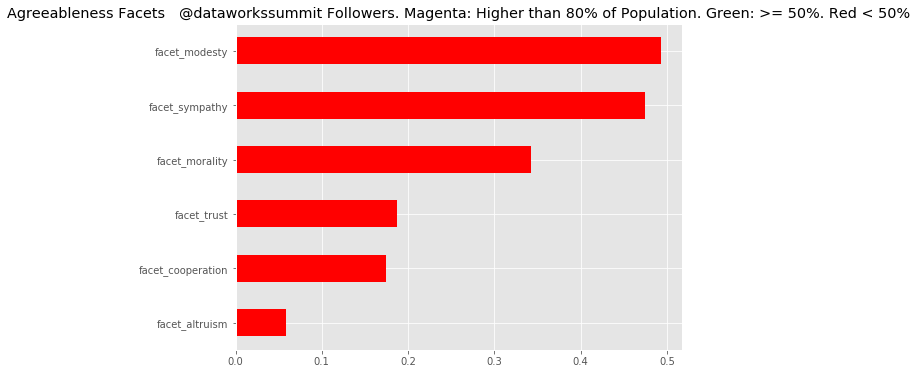

In [15]:
#Plotting Agreeableness Facets 
plotalltraits(["facet_altruism","facet_cooperation","facet_modesty","facet_morality","facet_sympathy","facet_trust"], PIDataDF.mean(axis=0),0.5,"Agreeableness Facets", "   @"+account+ " Followers. Magenta: Higher than 80% of Population. Green: >= 50%. Red < 50%")


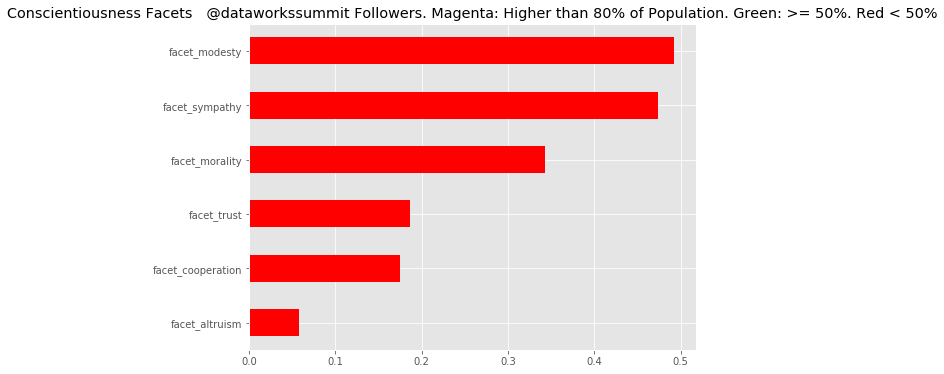

In [16]:
#Plotting Conscientiousness Facets 
plotalltraits(["facet_altruism","facet_cooperation","facet_modesty","facet_morality","facet_sympathy","facet_trust"], PIDataDF.mean(axis=0),0.5,"Conscientiousness Facets","   @"+account+ " Followers. Magenta: Higher than 80% of Population. Green: >= 50%. Red < 50%")

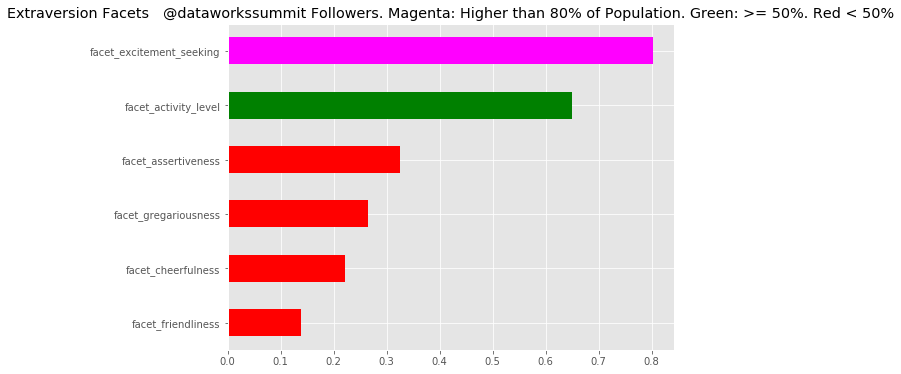

In [17]:
#Plotting Extraversion Facets 
plotalltraits(["facet_activity_level","facet_assertiveness","facet_cheerfulness","facet_excitement_seeking","facet_friendliness","facet_gregariousness"], PIDataDF.mean(axis=0),0.5,"Extraversion Facets", "   @"+account+ " Followers. Magenta: Higher than 80% of Population. Green: >= 50%. Red < 50%")

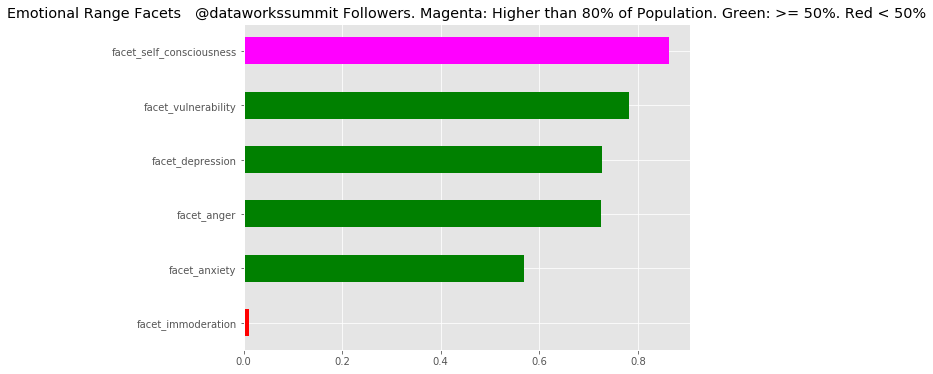

In [18]:
#Plotting Emotional Range Facets 
plotalltraits(["facet_anger","facet_anxiety","facet_depression","facet_immoderation","facet_self_consciousness","facet_vulnerability"], PIDataDF.mean(axis=0),0.5,"Emotional Range Facets", "   @"+account+ " Followers. Magenta: Higher than 80% of Population. Green: >= 50%. Red < 50%")

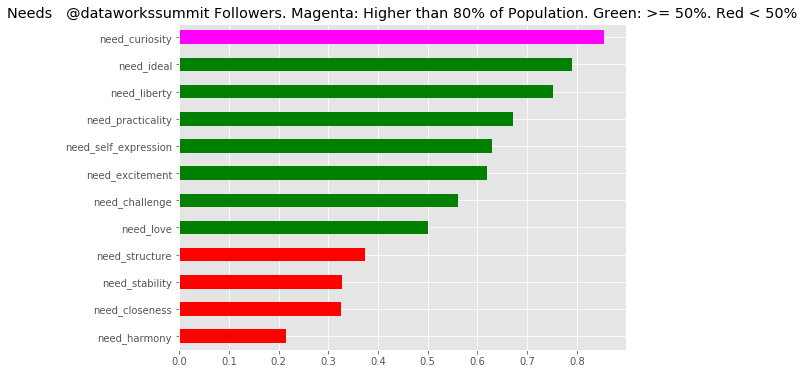

In [19]:
#Plotting Needs  
plotalltraits(["need_liberty","need_ideal","need_love","need_practicality","need_self_expression","need_stability","need_structure","need_challenge","need_closeness","need_curiosity","need_excitement","need_harmony"], PIDataDF.mean(axis=0),0.5,"Needs","   @"+account+ " Followers. Magenta: Higher than 80% of Population. Green: >= 50%. Red < 50%")
               

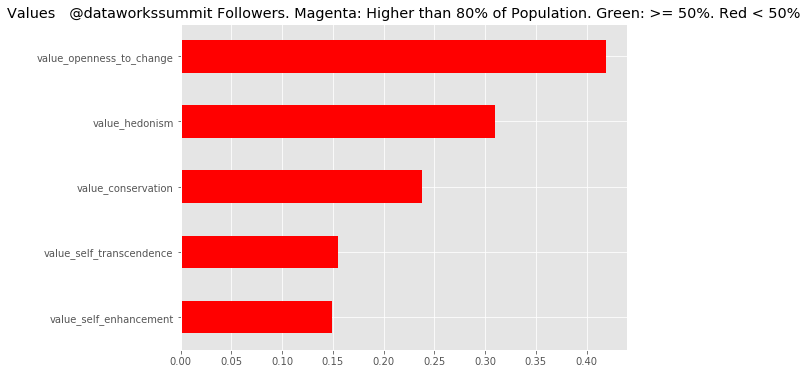

In [20]:
#Plotting Values
plotalltraits(["value_conservation","value_hedonism","value_openness_to_change","value_self_enhancement","value_self_transcendence"], PIDataDF.mean(axis=0),0.5,"Values", "   @"+account+ " Followers. Magenta: Higher than 80% of Population. Green: >= 50%. Red < 50%")

## Running clustering Analysis on the Needs Facets of the Personality Profile for @dataworkssummit followers to look for natural segments

In [21]:
#This function calculates the WSSSE for the different number of clusters in clustering analysis

def error(point): 
    center = clusters.centers[clusters.predict(point)] 
    print("center",center)
    return sqrt(sum([x**2 for x in (point - center)]))



In [23]:
#clustering spark 2.3  
PIneeds = PIDataDF.filter(regex='need')
PIneeds = PIneeds[PIneeds.columns.drop(list(PIneeds.filter(regex='significant')))]

In [24]:
#creates rdd 
from pyspark.mllib.clustering import KMeans, KMeansModel
PIneedssparkDF = sqlContext.createDataFrame(PIneeds)
#Converts to rdd to run clustering algorithm
rdddata=PIneedssparkDF.rdd.map(tuple)

In [25]:
#Runs the cluster algorithm for k values 1 to 10 in order to determine ideal k 10-1-18
wss=[]
for i in range(1,10):
    clusters = KMeans.train(rdddata, i, maxIterations=100)
    WSSSE = (rdddata.map(lambda point:error(point)).reduce(lambda x, y: x+y))
    print("with ",str(i),' ','Within Set Sum of Squared Error = ' , str(WSSSE))
    wss.append(WSSSE)


with  1   Within Set Sum of Squared Error =  109.93871902251809
with  2   Within Set Sum of Squared Error =  94.69849532208211
with  3   Within Set Sum of Squared Error =  89.1371509233106
with  4   Within Set Sum of Squared Error =  83.30978409856131
with  5   Within Set Sum of Squared Error =  80.37587894731749
with  6   Within Set Sum of Squared Error =  79.32859923077513
with  7   Within Set Sum of Squared Error =  75.1550873993749
with  8   Within Set Sum of Squared Error =  74.77083805316101
with  9   Within Set Sum of Squared Error =  74.82728279426524


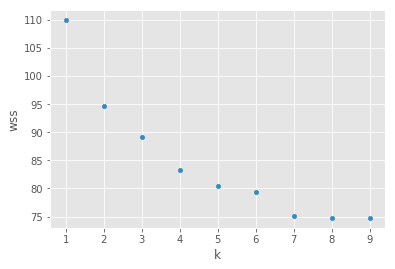

In [26]:
#Will use the "elbow" method to determine the ideal "k"
k=list(range(1, 10))
data = pd.DataFrame(
    {'k': k,
     'wss': wss,
    })
data.plot.scatter(x='k', y='wss')


In [27]:
#The "elbow" method tells us the ideal # of clusters/segments for this audience based on personality and the answer is 3

#We run the algorithm with K  = 3 clusters to get the cluster centers
clusters = KMeans.train(rdddata, 3, maxIterations=100)
#I now want to determine the size of these clusters.
#I create a prediction for each observation to determine in which cluster they will fall
cluster_ind = clusters.predict(rdddata)


In [28]:
#Count the observations on each resulting cluster
cluster_sizes = cluster_ind.countByValue().items()
total_obs=sum([pair[1] for pair in cluster_sizes])
for clusternumber in cluster_sizes:
    print ("Cluster Number ",clusternumber[0]," has ", clusternumber[1], " followers", round((clusternumber[1]/total_obs)*100,2)," % of sample")



Cluster Number  0  has  65  followers 22.73  % of sample
Cluster Number  1  has  59  followers 20.63  % of sample
Cluster Number  2  has  162  followers 56.64  % of sample


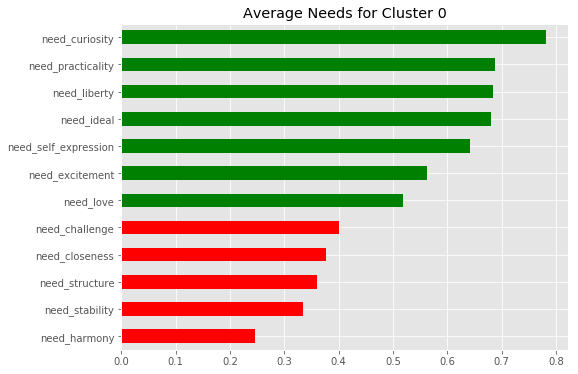

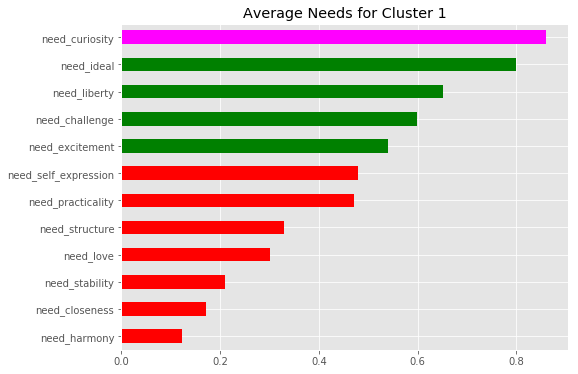

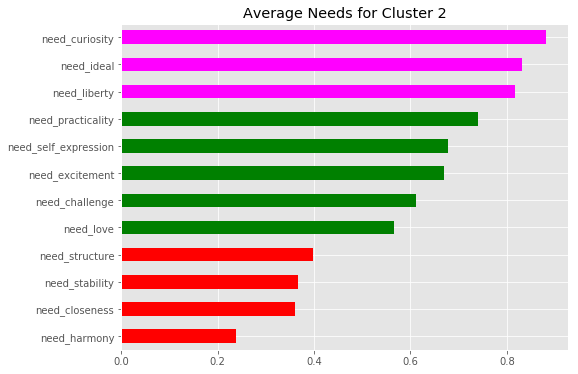

In [29]:
#Cluster Visualizations 
PINames= list(PIneeds.columns.values)
finalclusters= pd.DataFrame(data=clusters.clusterCenters,columns=PINames)
for i in range(0,3):
    plotadf(finalclusters.iloc[i].sort_values(),0.5,"Average Needs"," for Cluster "+str(i))
